Student: Antonio Neto

**Data Science Tracks – Air Quality Index Forecasting**

a) Load the Air Quality Index Dataset (or link available in https://archive.ics.uci.edu/dataset/360/air+quality

b) Plot the target data NO₂ (G7).

c) Adjust target data.

d) Use time series split (5 splits).

e) Compare 3 regression models (Linear Regression, Random Forest, Naïve).

f) Check MSE and MAE.

**Data Project Management Track – Air Quality Index Project Planning**


a) Detail the dataset info.

b) Plan project steps according to: CRISP-DM, KDD, or TDSP.


Saving AirQualityUCI.csv to AirQualityUCI (13).csv
Arquivo 'AirQualityUCI (13).csv' carregado com sucesso!

Valores faltantes após pré-processamento:
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

Treinando Regressão Linear...

Treinando Random Forest...

Treinando Persistência...

Comparação de Desempenho:


,MSE (Média),MAE (Média),MSE (Desvio Padrão),MAE (Desvio Padrão)
Student_Antonio,,,,
Regressão Linear,905.706111,22.265713,326.205006,3.935949
Random Forest,997.527175,23.372359,323.032611,3.871336
Persistência,5718.529594,62.301533,3211.305568,20.974122


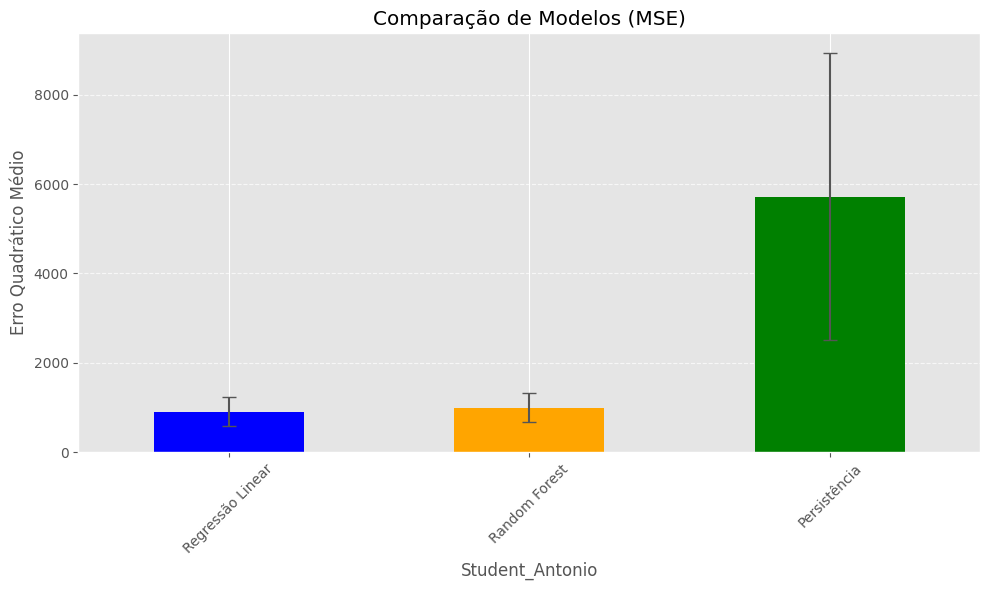


Processo concluído com sucesso!


In [22]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import io

# Upload do arquivo .csv
uploaded = files.upload()
file_name = next(iter(uploaded))
print(f"Arquivo '{file_name}' carregado com sucesso!")

class PersistenceModel:
    """Modelo de persistência (yₜ₊₁ = yₜ)"""
    def __init__(self):
        self.last_y = None

    def fit(self, X, y):
        self.last_y = y[-1] if len(y) > 0 else 0
        return self

    def predict(self, X):
        return np.full(X.shape[0], self.last_y)

# Carregar dados
df = pd.read_csv(
    io.BytesIO(uploaded[file_name]),
    delimiter=';',
    decimal=','
)


df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df = df.dropna(subset=['timestamp'])
df.set_index('timestamp', inplace=True)
df.drop(['Date', 'Time', 'Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True, errors='ignore')

numeric_cols = [
    'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
    'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
    'T', 'RH', 'AH'
]

for col in numeric_cols:
    if df[col].dtype == object:
        df[col] = df[col].str.replace(',', '.').astype(float)

df.replace(-200, np.nan, inplace=True)
df = df.interpolate(method='linear')
df.fillna(method='ffill', inplace=True)

print("\nValores faltantes após pré-processamento:")
print(df.isnull().sum())

df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

features = [
    'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
    'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
    'hour', 'day_of_week', 'month'
]

X = df[features]
y = df['NO2(GT)'].values

tscv = TimeSeriesSplit(n_splits=5)

# Definir modelos
models = {
    "Regressão Linear": make_pipeline(StandardScaler(), LinearRegression()),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Persistência": PersistenceModel()
}

results = {
    'Student_Antonio': [],
    'MSE (Média)': [],
    'MAE (Média)': [],
    'MSE (Desvio Padrão)': [],
    'MAE (Desvio Padrão)': []
}

for model_name, model in models.items():
    print(f"\nTreinando {model_name}...")
    mse_scores = []
    mae_scores = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse_scores.append(mean_squared_error(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))

    results['Student_Antonio'].append(model_name)
    results['MSE (Média)'].append(np.mean(mse_scores))
    results['MAE (Média)'].append(np.mean(mae_scores))
    results['MSE (Desvio Padrão)'].append(np.std(mse_scores))
    results['MAE (Desvio Padrão)'].append(np.std(mae_scores))

# ========== Resultados ==========
results_df = pd.DataFrame(results).set_index('Student_Antonio')
print("\nComparação de Desempenho:")
display(results_df)

# Visualização
plt.figure(figsize=(10, 6))
results_df['MSE (Média)'].plot(kind='bar',
                              yerr=results_df['MSE (Desvio Padrão)'],
                              color=['blue', 'orange', 'green'],
                              capsize=5)
plt.title('Comparação de Modelos (MSE)')
plt.ylabel('Erro Quadrático Médio')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nProcesso concluído com sucesso!")

The study compared three modeling approaches for forecasting NO₂ concentrations: Linear Regression, Random Forest, and a Persistence model (yₜ₊₁ = yₜ). Results showed both machine learning methods significantly outperformed the naive Persistence approach, with Linear Regression achieving the lowest MSE (905.71 vs. 5718.53 for Persistence), demonstrating that NO₂ levels require multivariate analysis rather than simple repetition of previous values. While Random Forest performed slightly worse than Linear Regression (MSE: 997.53), both models showed consistent results (low standard deviations) and benefited from temporal feature engineering (hour/day/month variables), confirming their reliability for air quality prediction.

The findings reveal weak temporal autocorrelation in NO₂ concentrations, as evidenced by the Persistence model's poor performance. Surprisingly, the simpler Linear Regression matched or surpassed the Random Forest's accuracy, suggesting complex nonlinear relationships may be less critical for this specific prediction task. This experiment highlights how even basic machine learning techniques, when properly implemented with temporal features, can substantially improve environmental forecasting compared to naive methods, offering practical solutions for air quality monitoring systems where computational resources may be limited.